# Routing quantum operations

In this notebook we will cover the QGym 'Routing' environment.

This environment is aimed at enabling to execute the quantum circuit by putting those physical qubits into connection that have an interaction in the quantum circuit. This problem arises when there are mismatches between the interaction graph and
the QPU-topology in the initial mapping.

### Circuits

The routing problem consist of scheduling the operations described by a quantum circuit.

The quantum circuit is represented as an **interaction graph**, where each node represent a qubit and each edge represent an
interaction between two qubits as defined by the circuit (See the example below). The QPU structure is called the **connection graph**. In the connection graph each node represents a physical qubit and each edge represent a connection between two qubits in the QPU.

.. code-block:: console

              QUANTUM CIRCUIT                        INTERACTION GRAPH
           ┌───┐               ┌───┐
    |q3>───┤ R ├───┬───────────┤ M ╞══                 q1 ────── q2
           └───┘   │           └───┘                            ╱
           ┌───┐ ┌─┴─┐         ┌───┐                           ╱
    |q2>───┤ R ├─┤ X ├───┬─────┤ M ╞══                        ╱
           └───┘ └───┘   │     └───┘                         ╱
           ┌───┐       ┌─┴─┐   ┌───┐                        ╱
    |q1>───┤ R ├───┬───┤ X ├───┤ M ╞══                     ╱
           └───┘   │   └───┘   └───┘                      ╱
           ┌───┐ ┌─┴─┐         ┌───┐                     ╱
    |q0>───┤ R ├─┤ X ├─────────┤ M ╞══                q3 ─────── q4
           └───┘ └───┘         └───┘


A SWAP-gate changes the mapping from logical qubits to physical qubits at a certain point in the circuit, and thereby allows to solve mismatchings from the initial mapping. The goal is to place SWAP-gates in the quantum circuit to fix the mismatches. The least amount of SWAP-gates is preferred. In more advanced setups, also different factors can be taken into account, like the fidelity of connections in the QPU.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
from networkx.generators import gnp_random_graph
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv
from IPython.display import clear_output

from qgym.envs.routing import *

In [2]:
def render_rgb(env):
    """Convenience method that we will use later on to display our results."""
    clear_output(wait=True)
    plt.figure(figsize=(40, 20))
    plt.title(f"Step {env._state.steps_done}", fontsize=40)
    plt.imshow(env.render())
    plt.axis("off")
    plt.show()

### Connection and interaction graph
The routing problem is focussed around three things: 
1. the interaction circuit: an abstracted version of the quantum circuit. It does not show what gates are executed and leaves out single qubit gates. Instead it show for all multi-qubit gates between which qubits the gates are executed,
2. the connection graph: the QPU structure showing between which physical qubits a gate can be executed,
3. the mapping: the mapping from logical qubits to physical qubits.

The goal of the routing problem is to place swap gates at the right places in the quantum circuit such that every multi-qubit gate within interaction circuit can be executed.

##### Toy hardware
To explain this concept in more detail we start by defining a toy connection graph and by taking a look at some interaction circuits.

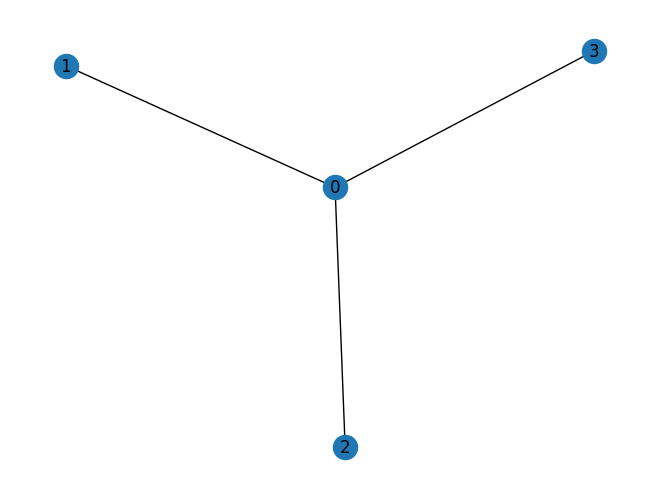

In [3]:
connection_graph = nx.Graph()
connection_graph.add_edges_from([(0, 1), (0, 2), (0, 3)])
nx.draw(connection_graph, with_labels=True)

### `Routing` environment

Let us initialize the `Routing` environment.

The `Routing` environment can be initialized by providing the following input:
- max_interaction_gates: Sets the maximum amount of gates in the `interaction_circuit`, when a new `interaction_circuit` is generated.
- max_observation_reach: Sets a cap on the maximum amount of gates the agent can see ahead when making an observation. When bigger that`max_interaction_gates` the agent will always see all gates ahead in an observation.
- observe_legal_surpasses: If ``True`` a boolean array of length `observation_reach` indicating whether the gates ahead can be executed, will be added to the `observation_space`.
- observe_connection_graph: If ``True``, the connection_graph will be incorporated in the observation_space. Reason to set it ``False`` is: QPU-topology practically doesn't change a lot for one machine, hence an agent is typically trained for just one QPU-topology which can be learned implicitly by rewards and/or the booleans if they are shown, depending on the other flag above.
- connection_graph: ``networkx`` graph representation of the QPU topology. Each node represents a physical qubit and each node represents a connection in the QPU topology.
- connection_graph_matrix: Adjacency matrix representation of the QPU topology.
- connection_grid_size: Size of the connection graph when the connection graph has a grid topology. For more information on the allowed values and types, see ``networkx`` `grid_graph`_ documentation.
- rewarder: Rewarder to use for the environment. Must inherit from ``qgym.Rewarder``. If ``None`` (default), then ``BasicRewarder`` is used.
- render_mode: If 'human' open a ``pygame`` screen visualizing the step. If 'rgb_array', return an RGB array encoding of the rendered frame on each render call.

Note here that it is possible to give the input on the connection graph in three possible ways, preferably only one option is given. If more are given, it is parsed by choosing chronologically the first input.

In [4]:
env = Routing(
    max_interaction_gates=10,
    max_observation_reach=5,
    observe_legal_surpasses=True,
    observe_connection_graph=True,
    connection_graph=connection_graph,
    render_mode="human",
)

#### State space
The state space is described by a `State` with the following structure:
- max_interaction_gates: Sets the maximum amount of gates in the interaction_circuit, when a new interaction_circuit is generated.
- max_observation_reach: Sets a cap on the maximum amount of gates the agent can see ahead when making an observation. When bigger than max_interaction_gates the agent will always see all gates ahead in an observation.
- connection_graph: ``networkx`` graph representation of the QPU topology. Each node represents a physical qubit and each edge represents a connection in the QPU topology.
- observe_legal_surpasses: If ``True`` a boolean array of length max_observation_reach indicating whether the gates ahead can be executed, will be added to the `observation_space`.
- observe_connection_graph: If ``True``, the connection_graph will be incorporated in the `observation_space`. Reason to set it ``False`` is: QPU-topology doesn't change, hence an agent could infer the topology from the training data without needing to explicitly add it to the observations. This reduced the size `observation_space`.

### To Do
Take a look at the state space in the code block below.

In [5]:
# todo: take a look at the state space

#### Action space
A valid action is a tuple of integers $(i,j, k)$, such that $i \in \{0, 1\}$ and $0 \leq j, k < n,$ where $n$ is the number of physical qubits. If $i=0:$ a SWAP-gate is applied to the physical qubits where logical qubits $j$ and $k$ are mapped unto, this action is called 'a swap'. If $i=1:$ the first observed gate will be surpassed, this action is called 'a surpass'.

A swap ($i=0$) is legal when:
1. $j$ and $k$ are not equal; and
2. the physical qubits corresponding to logical qubits $j$ and $k$ have a connection in the connection graph.

### To Do
Take a look at the action space in the code block below.

In [6]:
# todo: take a look at the action space

#### Observation space

For this environment the entries that are in the observation space are chosen depending on the two flags `observe_connection_graph` and `observe_legal_surpasses`.

Since we have chosen them to be both true, in our example each element in the observation space is a dictionary with tfour entries:
- `interaction_gates_ahead`: the current state of the mapping
- `mapping`: the flattened adjacency matrix of the interaction graph
- `connection_graph`: the flattened adjacency matrix of the interaction graph
- `is_legal_surpass`: the flattened adjacency matrix of the interaction graph

### To Do
Take a look at the observation space and see what the reset() method returns in the code block below.

In [7]:
# todo: take a look at the observation space and see what the reset() method returns

#### Rewarders

We have pre-defined 3 different rewarders, all of which return a penalty when an illegal action is attempted, for a valid action their behaviour is as follows:

- `BasicRewarder`: Every step either a penalty is given for an illegal action or for placing a SWAP or a reward is given for surpass the upcoming interaction gate.
- `SwapQualityRewarder`: Has an adjusted penalty w.r.t. the ``BasicRewarder`` in the sense that good SWAPs give lower penalties and bad SWAPs give higher penalties. A SWAP is good if the number of observable upcoming gates that can be executed without an extra SWAP increases, a SWAP is bad if this number decreases.
- `EpisodeRewarder`: Only gives a reward after at the end of a full episode. The reward is the highest for the lowest amount of SWAPs.

All these rewarders can be tweaked by altering either of their parameters:

- `illegal_action_penalty`: Penalty given for attempting an illegal action (should be non-positive).
- `penalty_per_swap`: Penalty for placing a swap (should be non-positive).
- `reward_per_surpass`: Reward given for surpassing a gate (should be positive).

<br/>
<br/>
<br/>
<br/>

### Reinforcement learning

Can we achieve a good route given our interaction circuit with reinforcement learning?

Does changing the rewarder and/or its parameter give better results?

### To Do
Use the first code block to use your favorite rewarder.
Next, use the second code block to train an agent.

In [8]:
# todo: pick your favorite rewarder
env.rewarder = BasicRewarder

In [9]:
# todo: train a model on this environment.

model.save("routing_1")

NameError: name 'model' is not defined

From the circuit below abstract the relevant interaction circuit, give it to the agent and see what kind of schedule the agent produces.

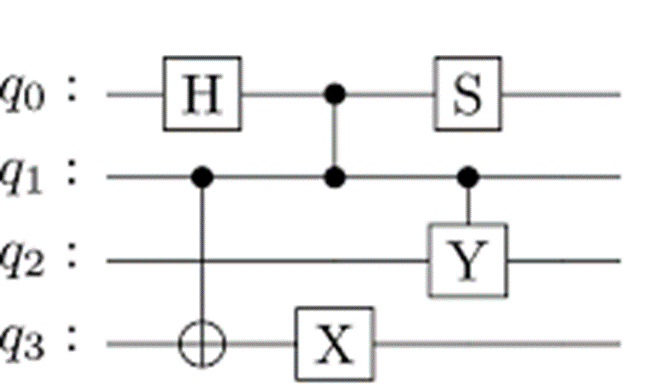

### To Do
Implement the corresponding interaction circuit in the first code block.
Use the second code block to see how well the agent schedules the circuit.

In [ ]:
# todo: write the interaction circuit below, an interaction circuit is an array of 2-tuples of integers
interaction_circuit = [(1, 3), (), ()]

In [ ]:
model = PPO.load("routing_1")
obs, extra_info = env.reset(options={"interaction_circuit": interaction_circuit})
for _ in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, truncated, info = env.step(action)
    render_rgb(env)
    if done:
        break

This probably gives quite some feeling of what is happening. Let's now try to do it for randomly generated circuits.

In [ ]:
obs, extra_info = env.reset()
for _ in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, truncated, info = env.step(action)
    render_rgb(env)
    if done:
        break

<br/>
<br/>
<br/>
<br/>

### Different Rewarders

Up to now, we have only used the `BasicRewarder`. However, we can also try out different rewarders and see what the effect is.
The other preset rewarders in this environment are the `SwapQualityRewarder` and the `EpisodeRewarder`.

### To Do
Choose one of the other rewarders and train an agent on it on the circuit you had before and after that on some random circuits.

In [ ]:
env.rewarder = ...

Train with this other rewarder

In [ ]:
...
model.save("routing_2")

See what the prediction is on the same circuit as we had before.

In [ ]:
obs, extra_info = env.reset()
for _ in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, truncated, info = env.step(action)
    render_rgb(env)
    if done:
        break

You could play a bit with different rewarders and adding your own rewarders. 

Something to think about:
How easy is it to get the adjusted circuit, i.e. with inserted SWAP-gates, back? This is a post-processing step not yet implemented.